# A Spike protein sequences embedding approach for pattern recognition analysis

The aim of this notebook is to show how we can train a neural network to discriminate protein sequences according to their host species in order to use the weights of the trained neural network as protein sequences embeddings. This allows us to have a their numerical representation and to make interesting pattern recognition analysis.

# Setup

Let us import the common libriaries needed for the operations done later.

In [1]:
#Modules
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

#Modules to prepare protein sequences
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

#Modules to build the model
from tensorflow.keras.models import Sequential
from keras.layers import Bidirectional, LSTM
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import Dropout, Dense

#Modules to process embedding vectors
from numpy import savetxt, loadtxt

#Dimensionality reduction methods
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE

#Clustering
from sklearn.cluster import DBSCAN
from sklearn import metrics

# Dataset

We are going to use an opensource public dataset of protein sequences available [here](https://github.com/brianhie/viral-mutation). The dataset is a fasta file composed by header and protein sequence. The header is composed by the accession number from Uniprot, the type of protein, the host species and other information that we are not interested in for this analysis. Sample of the data is as follows :

$\gt$YP_009724390.1 |surface glycoprotein [Severe acute respiratory syndrome coronavirus 2]|Homo sapiens|China|Severe acute respiratory syndrome-related coronavirus|refseq| complete
MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT

A sequence in FASTA format begins with a single-line description, followed by lines of sequence data. The definition line (defline) is distinguished from the sequence data by a greater-than ($\gt$) symbol at the beginning. The word following the "$\gt$" symbol is the identifier of the sequence, and the rest of the line is the description.

Since the data is in fasta format, we can use **Bio.SeqIO.FastaIO**  library to read the dataset. Thus we define a function to read our fasta file:

In [2]:
def read_fasta(file_path, columns) :
    from Bio.SeqIO.FastaIO import SimpleFastaParser 
    with open("cov_all.fa") as fasta_file :  #Will close handle cleanly
        records = [] # create empty list
        for title, sequence in SimpleFastaParser(fasta_file):
            record = []
            title_splits=re.findall(r"[\w']+", title) # Data cleaning is needed
            
            record.append(title_splits[0])  #First values are ID ('append' adds element to a list)
            record.append(len(sequence)) #Second values are sequences lengths
            sequence = " ".join(sequence) #It converts into one line
            record.append(sequence) #Third values are sequences
                
            #Fourth column will contain the species
            if any(Sapientis in title_splits for Sapientis in ("Human","Homo sapiens","Homo")):
                record.append("Human")
            elif any(Chiroptera in title_splits for Chiroptera in ("Bat","bat")):
                record.append("Bat") #Bat
            elif any(Pholidota in title_splits for Pholidota in ("Pangolin","pangolin")):
                record.append("Pangolin")#Pangolin
            else:
                record.append("Others")
                
    
            records.append(record)
            
    return pd.DataFrame(records, columns = columns) #We have created a function that returns a dataframe

**Bio.SeqIO.FastaIO.SimpleFastaParser** iterates over fasta records as string tuples. For each record a tuple of two strings is returned, the FASTA title line (without the leading ‘$\gt$’ character), and the sequence (with any whitespace removed). The title line is not divided up into an identifier (the first word) and comment or description. You can find the documentation in [https://biopython.org](https://biopython.org/docs/1.79/api/Bio.SeqIO.FastaIO.html). Thanks to this, we have created a function that reads the fasta file and returns a dataframe that has four columns: the first one is the sequence id, the second one is the sequence length, the third is the amino acids sequence itsself and the fourth is the animal host species. 

In [3]:
data = read_fasta("cov_all.fa", columns=["id","sequence_length", "sequence", "animal"])

In [4]:
data.head()

,id,sequence_length,sequence,animal
0,YP_009724390,1273,M F V F L V L L P L V S S Q C V N L T T R T Q ...,Human
1,BCG52831,1273,M F V F L V L L P L V S S Q C V N L T T R T Q ...,Human
2,QKS65476,1273,M F V F L V L L P L V S S Q C V N L T T R T Q ...,Human
3,QKS65488,1273,M F V F L V L L P L V S S Q C V N L T T R T Q ...,Human
4,QKS65608,1273,M F V F L V L L P L V S S Q C V N L T T R T Q ...,Human


# Data Exploration

First, we can check the available classes (host species), which will be used for protein classification, and the number of data present in each class.

In [5]:
unique_classes = data.animal.unique()
print("Number of classes: ", len(unique_classes))
unique_classes
print(unique_classes)

Number of classes:  4
['Human' 'Others' 'Bat' 'Pangolin']


We can see that there are 4 unique classes in the dataset (that we know since we built the dataframe choosing ourselves the host species). Now let us check the class balance:

In [6]:
cnt = Counter(data.animal)
print(cnt) 

Counter({'Human': 26987, 'Others': 3596, 'Bat': 260, 'Pangolin': 10})


In [7]:
#In order to create a list
list_animal_counts=cnt.most_common()
type(cnt.most_common()) # list
list_animal_counts

[('Human', 26987), ('Others', 3596), ('Bat', 260), ('Pangolin', 10)]

Text(0.5, 1.0, 'Classes (host species) distribution in the dataset')

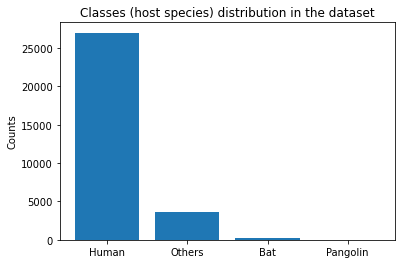

In [9]:
list_counts=[] # list of counts for each class
for Animal, Counts in list_animal_counts:
    list_counts.append(Counts)
list_counts

list_animal=[] # list of classes
for Animal, Counts in list_animal_counts:
    list_animal.append(Animal)
list_animal
   
fig, ax = plt.subplots()
ax.bar(list_animal, list_counts)
#plt.sca(ax)
ax.set_ylabel('Counts')
ax.set_title('Classes (host species) distribution in the dataset')

We can notice that we have to deal with class imbalance problem. Let us now check the sequence length distribution:

C:\Users\asus\miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


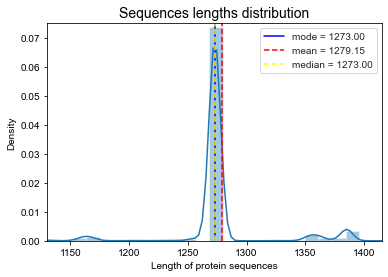

In [10]:
median = data['sequence_length'].median()
mean = data['sequence_length'].mean()
mode = data['sequence_length'].mode()[0]

#matplotlib inline
#config InlineBackend.figure_format='retina'
fig, ax = plt.subplots()
sns.set(style='whitegrid', palette='muted', font_scale=0.9)
plot= sns.distplot(data['sequence_length'],axlabel='Length of protein sequences').set_title('Sequences lengths distribution',fontsize=14)
ymax = 0.175
ax.plot([mode, mode], [0, ymax], '-', label=f'mode = {mode:.2f}', linewidth=1.5, color='blue')
ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=1.5, color='red')
ax.plot([median, median], [0, ymax], '--',
        label=f'median = {median:.2f}', linewidth=1.5,color='yellow')
#plt.xlim(900,1100) 
#plt.ylim(0,0.00025) 
plt.xlim(1130, 1415)
plt.ylim(0, 0.075)
plt.legend(fontsize='10')
plt.show()

The embedding layer of the neural network receives a fixed length of sentence as input. As you can see from the above plot that most of the sequences lie under the length of around 1273, therefore, its a good idea to select the max_length = 1273 but that will increase the training time for this sample notebook, therefore, we will use max_length = 350. You can experiment it with the bigger length and it does improves the accuracy as some information of protiens could be stored at the end of the sequence. Thus we will have to add paddings (empty tokens) to shorter sequences to make up the length and we will truncate those longer than 350 AAs. Anyway, in the undersampling method, we will analyse all sequences considering as input length the maximum one, that is:

In [12]:
maximum = data['sequence_length'].max()
maximum

1582

# Transform labels

Using **LabelEncoder** from **sklearn.preprocessing**, we encode target labels with value between 0 and n_classes-1.

In [5]:
lb = LabelEncoder()
Y = lb.fit_transform(data.animal) #subset_data.animal

#To get mapping of label encoder
lb_name_mapping= dict(zip(lb.classes_, lb.transform(lb.classes_)))
print(lb_name_mapping) 

{'Bat': 0, 'Human': 1, 'Others': 2, 'Pangolin': 3}


In [6]:
# Let us create a dataframe with only one column with labels (it will be used later) 
d = {'Labels':Y}
LabelDf=pd.DataFrame(d) 

# Further preprocessing of sequences

The sequences have different lengths and Keras prefers inputs to be vectorized and all inputs to have the same length.

In [7]:
# maximum length of sequence, everything afterwards is discarded!
max_length = 350 # 1582
seqs=data.sequence #subset_data.sequence
data.sequence

0        M F V F L V L L P L V S S Q C V N L T T R T Q ...
1        M F V F L V L L P L V S S Q C V N L T T R T Q ...
2        M F V F L V L L P L V S S Q C V N L T T R T Q ...
3        M F V F L V L L P L V S S Q C V N L T T R T Q ...
4        M F V F L V L L P L V S S Q C V N L T T R T Q ...
                               ...                        
30848    M F V F L V L L P L V S S Q C V N L T T R T Q ...
30849    M F V F L V L L P L V S S Q C V N L T T R T Q ...
30850    M F V F L V L L P L V S S Q C V N L T T R T Q ...
30851    T R G V Y Y P D K V F R S S V L H S T Q D L F ...
30852    M F V F L V L L P L V S S Q C V N L T T R T Q ...
Name: sequence, Length: 30853, dtype: object

The word embedding neural network layer does not accept directly the sequences in the form of strings or list of strings. We have to vectorize each sequence, by translating each token in the sentence to its index in the vocabulary.

In [8]:
#create the tokenizer
tokenizer = Tokenizer()
#fit the tokenizer
tokenizer.fit_on_texts(seqs)
#represent input data as symbol rank number sequences
X = tokenizer.texts_to_sequences(seqs)

print('symbol_index : ',tokenizer.word_index)

symbol_index :  {'l': 1, 's': 2, 'v': 3, 't': 4, 'n': 5, 'g': 6, 'a': 7, 'f': 8, 'i': 9, 'q': 10, 'd': 11, 'k': 12, 'p': 13, 'y': 14, 'e': 15, 'r': 16, 'c': 17, 'h': 18, 'm': 19, 'w': 20, 'b': 21, 'z': 22}


For sequences that are shorter than the maximum length, we will have to add paddings (empty tokens) to the sequences to make up the length.

In [9]:
padded_sequences = pad_sequences(X, maxlen=max_length, padding='post')
type(padded_sequences)

numpy.ndarray

# Training the LSTM network for sequence classification

We want to train a neural network that is a multilayer perceptron for multiclass classification. In particular, we train a neural network so that it can classify Spike protein sequences according to the host species they belong to. It is called *Sequence Classification problem* that is a predictive modeling problem where you have some sequence of inputs over space or time and the task is to predict a category for the sequence. In this case the categories are four: human host species, bat, pangolin and other animals class. 

In [10]:
#Set the number of classes
classes=4 

We train the network on 95% of the training set, and use the remaining 5% as validation set to monitor the improvement of the network during the training process.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, Y, test_size=0.05, shuffle=True, random_state=721)


We use a Recurrent Neural Network with Long Short-Term memory cells (LSTM network). We are dealing with sequences, that we could see also as time series data, and this kind of problem may require the model to learn the long-term dependencies between symbols in the input sequence. For this reason, we use an architecture with a layer composed of multiple LSTMs that process the input recursively with LTSM cells that remember values over arbitrary time intervals thanks to the three gates that regulate the flow of information into and out of the cell.

We expect (and "hope") that using this neural network model, the amino acids weights embedding vectors will have values that take into account dependencies between amino acids symbols as well as it would do for words in text.   

In this case, the first layer is the embedding layer that requires the size of the vocabulary (in our case we have 22 words, i.e. the number of amino acids and of unique symbols), the dimension of the embedding space and the length of input sequences.

Finally, given that it is a multiclass classification, the model must have one node for each class in the output layer and use the softmax activation function. The loss function is the *sparse_categorical_crossentropy*, which is appropriate for integer encoded class labels (e.g. 0 for one class, 1 for the next class, etc.).

In [12]:
#Set the dimension of embedding vectors
embedding_dim = 10 

#Create the model
model = Sequential()#1.Define a model
#With model.add() you add hidden layers.
model.add(Embedding(len(tokenizer.word_index)+1, embedding_dim, input_length=max_length, name='embeddings')) 
model.add(LSTM(units=64)) #Try without LSTM and with Biderectional(LSTM(64)) configuration
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Dropout(0.3))
model.add(Dense(classes,activation='softmax')) 
#model.add(Dense(1,activation='sigmoid')) for binary classification problem
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embeddings (Embedding)       (None, 350, 10)           230       
_________________________________________________________________
lstm (LSTM)                  (None, 64)                19200     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 23,850
Trainable params: 23,850
Non-trainable params: 0
____________________________________________________

In [13]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])#2.compile the model
#binary_crossentropy for binary classification problem

In [14]:
history = model.fit(X_train, y_train,  batch_size=128, validation_data=(X_test, y_test),verbose=2, epochs=15) #3.fit the model

Epoch 1/15
229/229 - 190s - loss: 0.3150 - accuracy: 0.9162 - val_loss: 0.1417 - val_accuracy: 0.9631
Epoch 2/15
229/229 - 190s - loss: 0.1118 - accuracy: 0.9671 - val_loss: 0.0761 - val_accuracy: 0.9793
Epoch 3/15
229/229 - 191s - loss: 0.0775 - accuracy: 0.9740 - val_loss: 0.0683 - val_accuracy: 0.9773
Epoch 4/15
229/229 - 182s - loss: 0.0701 - accuracy: 0.9755 - val_loss: 0.0655 - val_accuracy: 0.9793
Epoch 5/15
229/229 - 178s - loss: 0.0657 - accuracy: 0.9778 - val_loss: 0.0626 - val_accuracy: 0.9786
Epoch 6/15
229/229 - 183s - loss: 0.0644 - accuracy: 0.9770 - val_loss: 0.0613 - val_accuracy: 0.9786
Epoch 7/15
229/229 - 183s - loss: 0.0600 - accuracy: 0.9794 - val_loss: 0.0584 - val_accuracy: 0.9806
Epoch 8/15
229/229 - 170s - loss: 0.0605 - accuracy: 0.9802 - val_loss: 0.0669 - val_accuracy: 0.9767
Epoch 9/15
229/229 - 188s - loss: 0.0576 - accuracy: 0.9806 - val_loss: 0.0594 - val_accuracy: 0.9825
Epoch 10/15
229/229 - 173s - loss: 0.0555 - accuracy: 0.9820 - val_loss: 0.0591 - 

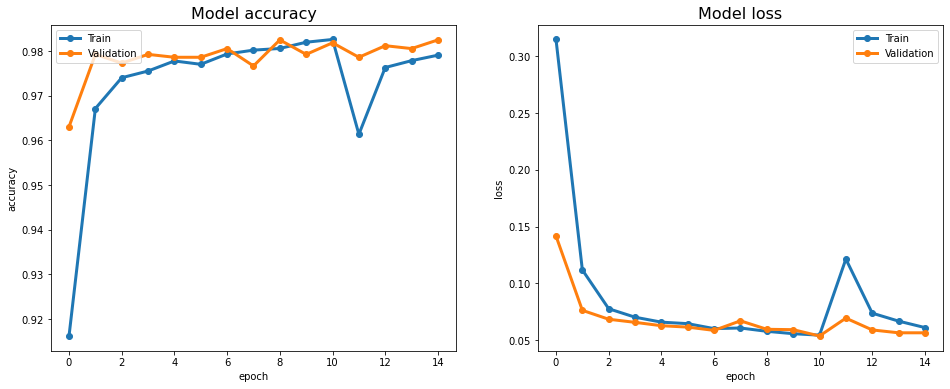

In [15]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history['accuracy'], label='Train',linestyle='-', linewidth=3, marker="o")
axis1.plot(history.history['val_accuracy'], label='Validation', linestyle='-', linewidth=3, marker="o")
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train',linestyle='-', linewidth=3, marker="o")
axis2.plot(history.history['val_loss'], label='Validation', linestyle='-', linewidth=3, marker="o")
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

We can notice that within these 15 epochs there is no sign of overfitting yet (that is a point in which the validation accuracy starts to keep constant and the validation loss starts to increase with the training loss that starts to decrease and the training accuracy increases). We could try to increase the number of epochs up to the point in which validation loss reaches its minimum.

Note: results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision.

In [16]:
# save embeddings
embeddings = model.get_layer('embeddings').get_weights()[0]

If you want to save weights to use it in an other moment to train other neural networks or in order to make data analysis in an other moment (as we have noticed from the time needed for each epoch, retraining is time expensive).

In [22]:
#Save embeddings in a txt file naming it with the characteristics of the neural network used to obtain them
embedding_saved=savetxt('EmbeddingsLengthMax350BatchSize128Epoche15AllDataLSTM.txt', embeddings, delimiter=',')

#load array to use them
embedding_loaded = loadtxt('EmbeddingsLengthMax350BatchSize128Epoche15AllDataLSTM.txt', delimiter=',')

This is the crucial part: how do we make sequences embeddings ? In this analysis, we calculate the sequence embedding as the average of the embeddings of each symbol (i.e. letter and token) of the sequence. Let us try:

In [17]:
#Here we put all the truncated and tokenized sequences
sequi=[]
for seq in X:
    truncated_sequence=seq[0:max_length]
    sequi.append(truncated_sequence)
 
doc_vecs = np.empty((0,embedding_dim), float) # Return a new array of given shape and type, without initializing entries
for i, doc in enumerate(sequi):  # Enumerate allows us to loop over all the tokenized sequences and have an automatic counter
  vec = np.empty((0,embedding_dim), float)
  for token in doc: # Doc is a list of integers, i.e. symbols assigned by Tokenizer  
    vec = np.append(vec, [embeddings[token]], axis=0)# let's fill vec with the vector embeddings of each token
  vec = vec.mean(axis=0)  
  #print(docs[i], "-->", vec)
  doc_vecs = np.append(doc_vecs, [vec], axis=0) # Let's fill doc_vecs with the vector embeddings of each sequence


Even in this case you can save these average vectors in case you want to use them in an other moment.

In [18]:
#Save average vectors in a txt file
doc_saved=savetxt('doc_vecsEmbeddingsLengthMax350BatchSize128Epoche15AllDataLSTM.txt', doc_vecs, delimiter=',')
#Load average vectors from a txt file
# load array to use them
doc_loaded = loadtxt('doc_vecsEmbeddingsLengthMax350BatchSize128Epoche15AllDataLSTM.txt', delimiter=',')

# Dimensionality reduction methods to visualize protein sequences embeddings

Now, these protein embeddings are 10-dimensional vectors so we can not visualize them in a plot. In order to reduce them to 2-dimensions, we use PCA, UMAP and t-SNE as dimensionality reduction methods.

In [20]:
#This is needed to assign colors to each label of the plots
list_label=[]
for Name in lb_name_mapping:
    list_label.append(lb_name_mapping[Name]) 

list_animal=[]
for Name in lb_name_mapping:
    list_animal.append(Name)

Here we apply Principal Component Analysis (PCA), that projects the data on the eigenvectors of the covariance matrix and reduces the dimensionality while conserving as much as possibile the variation present in the data.

In [22]:
pca = PCA(n_components=10)
embedding_PCA = pca.fit_transform(doc_vecs)#doc_loaded

First we can create two dataframes: one with all the components and one with the first two principal components.

In [23]:
n_components=[]
for n in range(10):
    n_components.append("PC"+str(n+1))
n_components

PrincipalComponents= pd.DataFrame(data=embedding_PCA, columns=n_components)
PrincipalComponents

#For the PCA plot we need the first two principal components
First_2_PrincipalComponents=PrincipalComponents[['PC1','PC2']]
FinalDf_PCA=pd.concat([First_2_PrincipalComponents,LabelDf[['Labels']]],axis=1)  
FinalDf_PCA

,PC1,PC2,Labels
0,-0.000572,-0.001380,1
1,-0.000572,-0.001380,1
2,-0.000572,-0.001380,1
3,-0.000572,-0.001380,1
4,-0.000572,-0.001380,1
...,...,...,...
30848,-0.000572,-0.001380,1
30849,-0.000572,-0.001380,1
30850,-0.002886,-0.002253,1
30851,-0.020878,0.006394,1


We can visualize the amount of variation accounted for by each principal component with a scree plot.

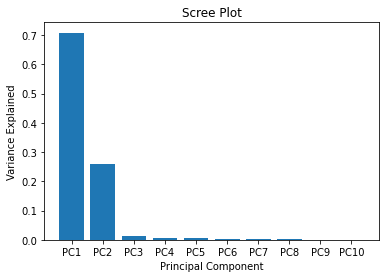

In [24]:
# Scree Plot    
PC_values = np.arange(pca.n_components_) + 1
plt.bar(PC_values, pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks(PC_values, n_components)
plt.show()

Let us see if we get an informative plot with a 2D graph with the first two principal components as x and y axis.

[7.07802891e-01 2.59390537e-01 1.38838630e-02 7.58065906e-03
 4.56105317e-03 2.72807664e-03 1.73060544e-03 1.56673020e-03
 4.39575775e-04 3.16009316e-04]


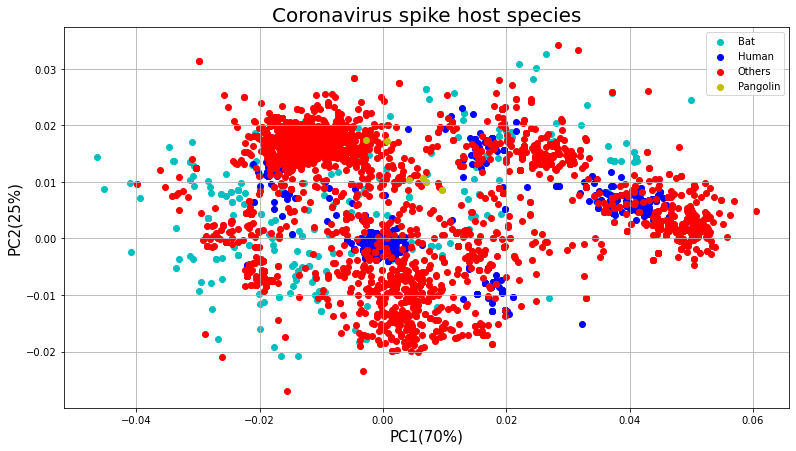

In [25]:
print(pca.explained_variance_ratio_)
type(pca.explained_variance_ratio_)
#It is a numpy array so you can select its first elements in this way:
Percentage_PC1=int(pca.explained_variance_ratio_[0]*100)
Percentage_PC2=int(pca.explained_variance_ratio_[1]*100)

fig= plt.figure(figsize=(13,7))
ax= fig.add_subplot(1,1,1)
ax.set_xlabel('PC1({}%)'.format(Percentage_PC1), fontsize=15)
ax.set_ylabel('PC2({}%)'.format(Percentage_PC2), fontsize=15)
ax.set_title('Coronavirus spike host species', fontsize=20)
#plt.xlim(-0.02,0.04)

colors=['c','b','r','y','k']
for label,color in zip(list_label,colors):
    indicesToKeep = FinalDf_PCA['Labels'] == label
    ax.scatter(FinalDf_PCA.loc[indicesToKeep,'PC1'],FinalDf_PCA.loc[indicesToKeep,'PC2'], c= color)
leg=ax.legend(list_animal)
ax.grid(True)

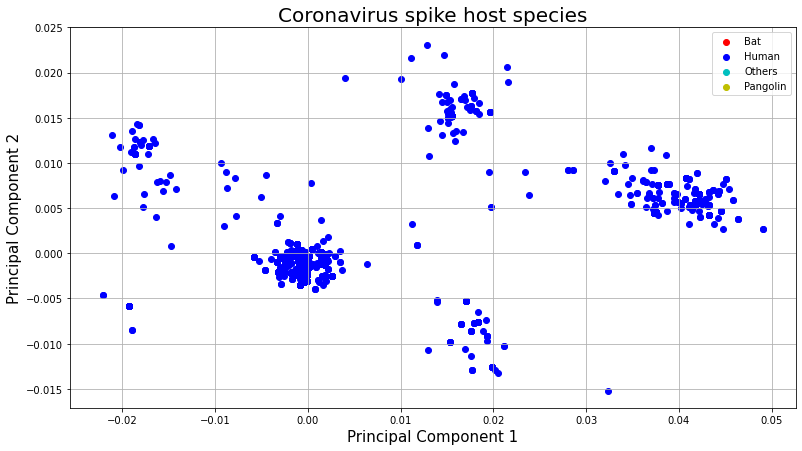

In [26]:
#If you want to visualize only a class, for example humans.

# Selecting rows by value in a floating point column in pandas
Subset_FinalDf_PCA=FinalDf_PCA[np.isclose(FinalDf_PCA['Labels'], 1)]
Subset_FinalDf_PCA

fig= plt.figure(figsize=(13,7))
ax= fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize=15)
ax.set_ylabel('Principal Component 2', fontsize=15)
ax.set_title('Coronavirus spike host species', fontsize=20)

colors=['r','b','c','y']
for label,color in zip(list_label,colors):
    indicesToKeep = Subset_FinalDf_PCA['Labels'] == label
    ax.scatter(Subset_FinalDf_PCA.loc[indicesToKeep,'PC1'], Subset_FinalDf_PCA.loc[indicesToKeep,'PC2'], c= color)
leg=ax.legend(list_animal)
ax.grid()

Now we can use dimensionality reduction methods that *aim to conserve local neighborhood structure* of the starting high dimensional space in a lower-dimensional space. They are based on a network description of space: we can consider the nodes as our samples and the links as the mutual distance. Let us start with umap for which the k-neighbors, whose structure has to be preserved, varies from node to node.

In [27]:
number_neighbors=100 #Try 100 15 50
reducer = umap.UMAP(n_neighbors=number_neighbors)#default=n_neighbors=15,metic="euclidian",min_dist=0.1,spread=1.0.
embedding_UMAP = reducer.fit_transform(doc_vecs)#doc_loaded

UMAPComponents= pd.DataFrame(data=embedding_UMAP, columns=['UMAP 1','UMAP 2'])
FinalDf_UMAP=pd.concat([UMAPComponents,LabelDf[['Labels']]],axis=1)  
FinalDf_UMAP

,UMAP 1,UMAP 2,Labels
0,19.952656,3.079746,1
1,21.011707,4.808840,1
2,21.689020,4.945815,1
3,18.339523,1.127447,1
4,19.762331,3.858864,1
...,...,...,...
30848,19.026453,3.583124,1
30849,18.720921,1.586143,1
30850,-17.548851,15.841380,1
30851,-4.623181,-1.265765,1


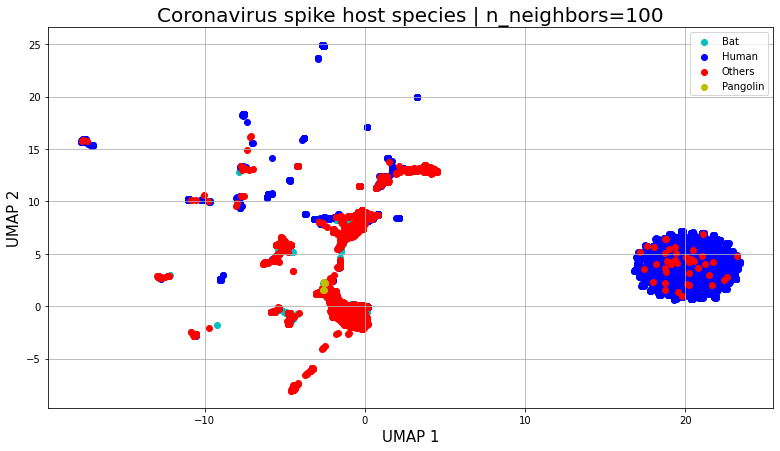

In [29]:
fig= plt.figure(figsize=(13,7))
ax= fig.add_subplot(1,1,1)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
ax.set_title('Coronavirus spike host species | n_neighbors={}'.format(number_neighbors), fontsize=20)
#plt.xlim(-31,-28)
#plt.ylim(4,6)

colors=['c','b','r','y','k']
for label,color in zip(list_label,colors):
    indicesToKeep = FinalDf_UMAP['Labels'] == label
    ax.scatter(FinalDf_UMAP.loc[indicesToKeep,'UMAP 1'], FinalDf_UMAP.loc[indicesToKeep,'UMAP 2'], c= color)
leg=ax.legend(list_animal)
ax.grid(True)

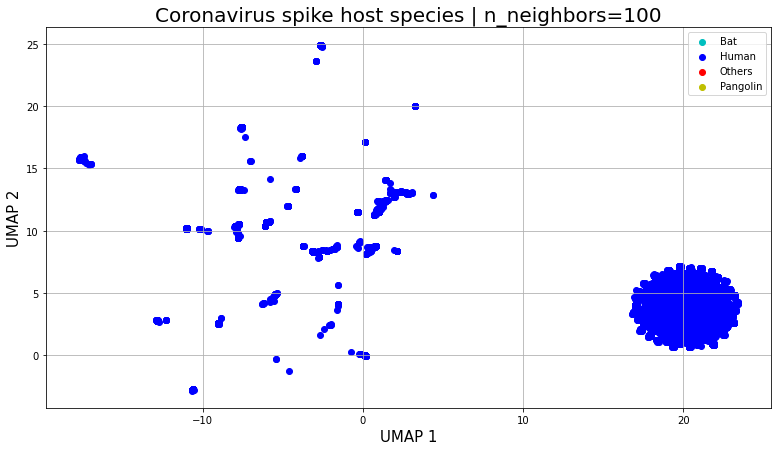

In [31]:
#If you want to visualize only a class, for example humans.

# Selecting rows by value in a floating point column in pandas
Subset_FinalDf_UMAP=FinalDf_UMAP[np.isclose(FinalDf_UMAP['Labels'], 1)]
Subset_FinalDf_UMAP

Subset_FinalDf_UMAP_Bat_Humans=FinalDf_UMAP.loc[FinalDf_UMAP['Labels'].isin([0,1])]
Subset_FinalDf_UMAP_Humans_Others=FinalDf_UMAP.loc[FinalDf_UMAP['Labels'].isin([1,2])]

fig= plt.figure(figsize=(13,7))
ax= fig.add_subplot(1,1,1)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
ax.set_title('Coronavirus spike host species | n_neighbors={}'.format(number_neighbors), fontsize=20)
#plt.xlim(-5,10)

colors=['c','b','r','y']
for label,color in zip(list_label,colors):
    indicesToKeep = FinalDf_UMAP['Labels'] == label
    ax.scatter(Subset_FinalDf_UMAP.loc[indicesToKeep,'UMAP 1'], Subset_FinalDf_UMAP.loc[indicesToKeep,'UMAP 2'], c= color)
leg=ax.legend(list_animal)
ax.grid()

Finally, let us apply t-SNE method that, similarly to umap, is based on a network description of our space and aims to preserve the local neighborhood structure but in this case the number of neighbors is fixed for each sample point.

In [32]:
perplexity_value=100 #Try 15, 30, 50 and 100 
embedding_TSNE = TSNE(n_components=2, perplexity=perplexity_value, learning_rate='auto', init='random').fit_transform(doc_vecs)
# It takes some time . More than the others !

TSNEComponents= pd.DataFrame(data=embedding_TSNE, columns=['TSNE 1','TSNE 2'])
FinalDf_TSNE=pd.concat([TSNEComponents,LabelDf[['Labels']]],axis=1)  
FinalDf_TSNE

,TSNE 1,TSNE 2,Labels
0,2.211827,0.895982,1
1,2.211813,0.895899,1
2,2.211850,0.896014,1
3,2.211813,0.895899,1
4,2.211850,0.896014,1
...,...,...,...
30848,4.701220,4.134859,1
30849,2.307143,-0.487009,1
30850,-18.738962,-3.896836,1
30851,-18.480871,-12.249511,1


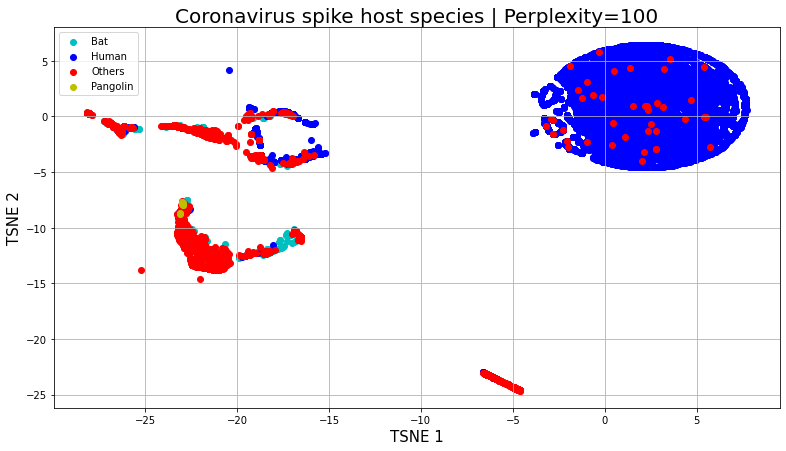

In [33]:
fig= plt.figure(figsize=(13,7))
ax= fig.add_subplot(1,1,1)
ax.set_xlabel('TSNE 1', fontsize=15)
ax.set_ylabel('TSNE 2', fontsize=15)
ax.set_title('Coronavirus spike host species | Perplexity={}'.format(perplexity_value), fontsize=20)
#plt.xlim(20,28)

colors=['c','b','r','y','k']
for label,color in zip(list_label,colors):
    indicesToKeep = FinalDf_TSNE['Labels'] == label
    ax.scatter(FinalDf_TSNE.loc[indicesToKeep,'TSNE 1'], FinalDf_TSNE.loc[indicesToKeep,'TSNE 2'], c= color)
leg=ax.legend(list_animal)
ax.grid(True)

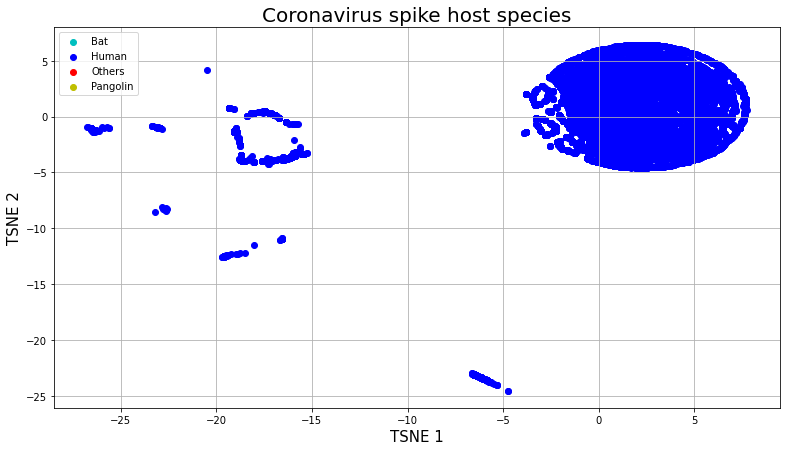

In [34]:
#If you want to visualize only a class, for example humans.

# Selecting rows by value in a floating point column in pandas
Subset_FinalDf_TSNE=FinalDf_TSNE[np.isclose(FinalDf_TSNE['Labels'], 1)]

fig= plt.figure(figsize=(13,7))
ax= fig.add_subplot(1,1,1)
ax.set_xlabel('TSNE 1', fontsize=15)
ax.set_ylabel('TSNE 2', fontsize=15)
ax.set_title('Coronavirus spike host species', fontsize=20)

colors=['c','b','r','y']
for label,color in zip(list_label,colors):
    indicesToKeep = Subset_FinalDf_TSNE['Labels'] == label
    ax.scatter(Subset_FinalDf_TSNE.loc[indicesToKeep,'TSNE 1'], Subset_FinalDf_TSNE.loc[indicesToKeep,'TSNE 2'], c= color)
leg=ax.legend(list_animal)
ax.grid() 

# Unsupervised analysis

We end up this notebook by applying DBScan clustering algorithm to check which patterns such an algorithm is able to detect without knowing labels a priori and too see how the Silhouette Score changes according to a DBScan parameter that is the number of neighbors that we vary in a finite range of values. 

In [38]:
dfClustering_TSNE = pd.DataFrame(FinalDf_TSNE,columns=['TSNE 1','TSNE 2'])
min_samples=3

SS_values=[]
eps_values=np.arange(0.1, 3.0, 0.1)
for eps in eps_values:
    DBScan = DBSCAN(eps, min_samples=3).fit(dfClustering_TSNE)
    labels = DBScan.labels_
    SS_values.append(metrics.silhouette_score(dfClustering_TSNE, labels))

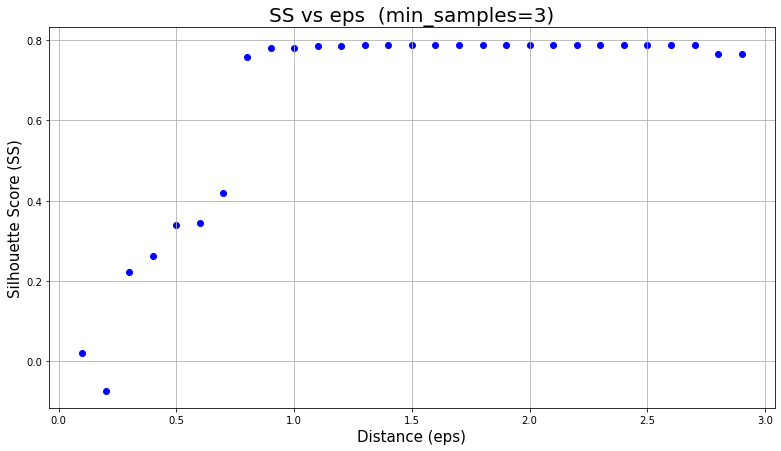

In [39]:
fig= plt.figure(figsize=(13,7))
ax= fig.add_subplot(1,1,1)
ax.set_xlabel('Distance (eps)', fontsize=15)
ax.set_ylabel('Silhouette Score (SS)', fontsize=15)
ax.set_title('SS vs eps  (min_samples={})'.format(min_samples), fontsize=20)
ax.scatter(eps_values,SS_values,c='b')
ax.grid()

Let us plot DBScan clustering algorithm results by setting the neighborhood radius value corresponding to the maximum value of the Silhoutte Score

Estimated number of clusters: 4
Estimated number of noise points: 2
Homogeneity: 0.687
Completeness: 0.429
V-measure: 0.528
Adjusted Rand Index: 0.716
Adjusted Mutual Information: 0.528
Silhouette Coefficient: 0.789


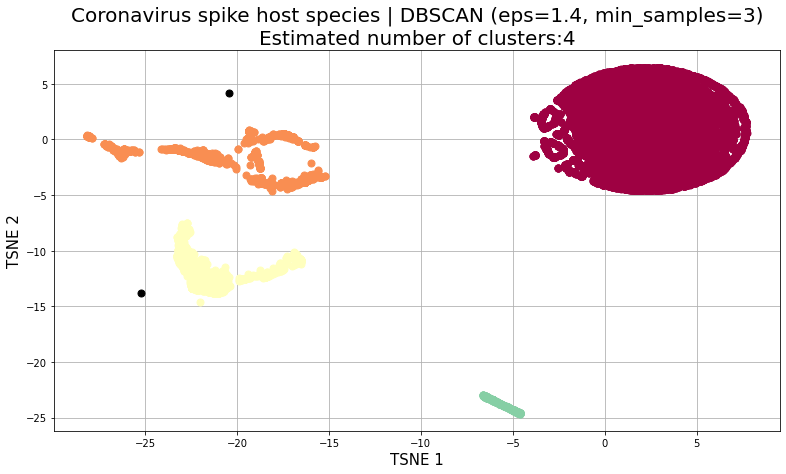

In [40]:
eps=1.4

DBScan = DBSCAN(eps, min_samples=3).fit(dfClustering_TSNE)
labels = DBScan.labels_
unique_labels = set(labels)

core_samples_mask = np.zeros_like(DBScan.labels_, dtype=bool)
core_samples_mask[DBScan.core_sample_indices_] = True
labels = DBScan.labels_

#It converts the dataframe into a one dimensional array
OneD_Labels=LabelDf[['Labels']].values.flatten()

#Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

#Plot result
fig= plt.figure(figsize=(13,7))
ax= fig.add_subplot(1,1,1)
#Black removed from colors
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        #Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = dfClustering_TSNE[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
        markeredgecolor=tuple(col), markersize=7)

    xy = dfClustering_TSNE[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor=tuple(col), markersize=7)

ax.set_xlabel('TSNE 1', fontsize=15)
ax.set_ylabel('TSNE 2', fontsize=15)
ax.set_title('Coronavirus spike host species | DBSCAN (eps={}, min_samples={})\nEstimated number of clusters:{}'
             .format(eps,min_samples,n_clusters_), fontsize=20)
ax.grid()



print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(OneD_Labels, labels))
print("Completeness: %0.3f" % metrics.completeness_score(OneD_Labels, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(OneD_Labels, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(OneD_Labels, labels))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(OneD_Labels, labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(dfClustering_TSNE, labels))

# Further pattern recognition analysis to solve imbalanced data classes problem

In this notebook we have shown the Python code and the results of this protein sequences embeddings analysis using imbalanced data. In **results and discussion** of the report provided, we discuss also results that come out from two methods that try to deal with the imbalanced data problem: the first one is training the same LSTM neural network model on 260 human protein sequences, 260 bat protein sequences and 260 other animals protein sequences (*undersampling* method); the second one is to divide the most abundant classes (among humans, bats and other animals) in N subsets, each one with 260 data, that is the amount of data of the minority class (bats), and we train our neural network classifier sequentially on a N-th subset of the majority classes but on all of the data from the rare class. 

# Undersampling method

We select subsets based on the minimum number among the three class (humans, bats and other animals) using **groupby**. We do not consider pangolin class as it has very few number of data to train LSTM.

In [43]:
def read_fasta(file_path, columns) :
    from Bio.SeqIO.FastaIO import SimpleFastaParser 
    with open("cov_all.fa") as fasta_file :  #Will close handle cleanly
        records = [] # create empty list
        for title, sequence in SimpleFastaParser(fasta_file):
            record = []
            title_splits=re.findall(r"[\w']+", title) # Data cleaning is needed
            
            record.append(title_splits[0])  #First values are ID ('append' adds element to a list)
            record.append(len(sequence)) #Second values are sequences lengths
            sequence = " ".join(sequence) #It converts into one line
            record.append(sequence) #Third values are sequences
                
            #Fourth column will contain the species
            if any(Sapientis in title_splits for Sapientis in ("Human","Homo sapiens","Homo")):
                record.append("Human")
            elif any(Chiroptera in title_splits for Chiroptera in ("Bat","bat")):
                record.append("Bat") #Bat
            elif any(Pholidota in title_splits for Pholidota in ("Pangolin","pangolin")):
                record.append("")#Pangolin
            else:
                record.append("Others")
                
    
            records.append(record)
            
    return pd.DataFrame(records, columns = columns) #We have created a function that returns a dataframe

In [44]:
data = read_fasta("cov_all.fa", columns=["id","sequence_length", "sequence", "animal"])

In [45]:
#Remove rows with empty strings

data["animal"].replace("", np.nan, inplace=True)

data.dropna(subset = ["animal"], inplace=True)

In [46]:
#First we shuffle data
shuffled_data =data.sample(frac=1, random_state=1).reset_index(drop=True) 
#random_state for reproducibility
#frac=1 specifies the fraction of rows to return in the random sample, so frac=1 means return all rows (in random order).

#Select subset dataset
grouped = shuffled_data.groupby('animal')
subset_data = (grouped.head(grouped.size().min())).reset_index(drop=True)

In [47]:
cnt = Counter(subset_data.animal)
print(cnt)

Counter({'Human': 260, 'Others': 260, 'Bat': 260})


We repeat the same analysis just by substituting *data* with *subset_data* where it occurs and changing the number of classes to 3 before running the neural network model.

# Third method

As regards the third method instead, we still use **sample** to shuffle data and **groupby** to select subset based on the number of data of the minority class and in this case the code is the reported below.

In [ ]:
def read_fasta(file_path, columns) :
    from Bio.SeqIO.FastaIO import SimpleFastaParser 
    with open("cov_all.fa") as fasta_file :  #Will close handle cleanly
        records = [] 
        for title, sequence in SimpleFastaParser(fasta_file):
            record = []
            title_splits=re.findall(r"[\w']+", title) 
            record.append(title_splits[0])  #First values are ID (Append adds element to a list)
            record.append(len(sequence)) #Second values are sequences lengths
            sequence = " ".join(sequence) #It converts into one line
            record.append(sequence)#Third values are sequences
                
            #Fourth column will contain the species
            if any(Sapientis in title_splits for Sapientis in ("Human","Homo sapiens","Homo")):
                record.append("Human")
            elif any(Chiroptera in title_splits for Chiroptera in ("Bat","bat")):
                record.append("Bat") #Bat
            elif any(Pholidota in title_splits for Pholidota in ("Pangolin","pangolin")):
                record.append("")#Pangolin
           else:
                record.append("Others")
            records.append(record)
    return pd.DataFrame(records, columns = columns) #We have created a function that returns a dataframe

In [ ]:
data = read_fasta("cov_all.fa", columns=["id","sequence_length", "sequence", "animal"])

In [ ]:
#Remove rows with empty strings

data["animal"].replace("", np.nan, inplace=True)

data.dropna(subset = ["animal"], inplace=True)

In [ ]:
#To have animal classes of equal size (without shuffling prior).
grouped = data.groupby('animal') 
subset_data = (grouped.head(grouped.size().min())).reset_index(drop=True)

#To have animal classes of equal size (with shuffling prior).
shuffled_data1 =data.sample(frac=1, random_state=1).reset_index(drop=True)

grouped1 = shuffled_data1.groupby('animal')
subset_data1 = (grouped.head(grouped.size().min())).reset_index(drop=True)

shuffled_data2 =data.sample(frac=1, random_state=2).reset_index(drop=True)

grouped2 = shuffled_data2.groupby('animal')
subset_data2 = (grouped.head(grouped.size().min())).reset_index(drop=True)

shuffled_data3 =data.sample(frac=1, random_state=3).reset_index(drop=True)

grouped3 = shuffled_data3.groupby('animal')
subset_data3 = (grouped.head(grouped.size().min())).reset_index(drop=True)

shuffled_data4 =data.sample(frac=1, random_state=4).reset_index(drop=True)

grouped = shuffled_data4.groupby('animal')
subset_data4 = (grouped.head(grouped.size().min())).reset_index(drop=True)

shuffled_data5 =data.sample(frac=1, random_state=5).reset_index(drop=True)

grouped5 = shuffled_data5.groupby('animal')
subset_data5 = (grouped5.head(grouped.size().min())).reset_index(drop=True)

shuffled_data6 =data.sample(frac=1, random_state=6).reset_index(drop=True)

grouped6 = shuffled_data6.groupby('animal')
subset_data6 = (grouped.head(grouped.size().min())).reset_index(drop=True)

shuffled_data7 =data.sample(frac=1, random_state=7).reset_index(drop=True)

grouped7 = shuffled_data7.groupby('animal')
subset_data7 = (grouped.head(grouped.size().min())).reset_index(drop=True)

In [ ]:
lb = LabelEncoder()

Y = lb.fit_transform(subset_data.animal) 

Y1= lb.fit_transform(subset_data1.animal) 

# Let us create a dataframe with only one column with labels (it will be used later) 
# We do it only for subset1 because we will represent only those protein sequences subset 
#(i.e. the ones of the previous undersampling method. random_state=1 ensures you have the same subset)
d = {'Labels':Y1}
LabelDf=pd.DataFrame(d) 

Y2= lb.fit_transform(subset_data2.animal) 
Y3= lb.fit_transform(subset_data3.animal) 
Y4= lb.fit_transform(subset_data4.animal) 
Y5= lb.fit_transform(subset_data5.animal) 
Y6= lb.fit_transform(subset_data6.animal) 
Y7= lb.fit_transform(subset_data7.animal) 

lb_name_mapping= dict(zip(lb.classes_, lb.transform(lb.classes_)))
print(lb_name_mapping) #To get mapping of label encoder

In [ ]:
#The sequences have different lengths and Keras prefers inputs to be vectorized and all inputs to have the same length.
# maximum length of sequence, everything afterwards is discarded! 
max_length = 350 
seqs=subset_data.sequence 
#The word embedding layer expects input sequences to be comprised of integers.
#create and fit tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(seqs)
#represent input data as word rank number sequences
X = tokenizer.texts_to_sequences(seqs)
print('word_index : ',tokenizer.word_index)
padded_sequences = pad_sequences(X, maxlen=max_length, padding='post')
type(padded_sequences)#numpy.ndarray

seqs1=subset_data1.sequence
tokenizer.fit_on_texts(seqs1)
X1=tokenizer.texts_to_sequences(seqs1)
padded_sequences1 = pad_sequences(X1, maxlen=max_length, padding='post')

seqs2=subset_data2.sequence
tokenizer.fit_on_texts(seqs2)
X2=tokenizer.texts_to_sequences(seqs2)
padded_sequences2 = pad_sequences(X2, maxlen=max_length, padding='post')

seqs3=subset_data3.sequence
tokenizer.fit_on_texts(seqs3)
X3=tokenizer.texts_to_sequences(seqs3)
padded_sequences3 = pad_sequences(X3, maxlen=max_length, padding='post')

seqs4=subset_data4.sequence
tokenizer.fit_on_texts(seqs4)
X4=tokenizer.texts_to_sequences(seqs4)
padded_sequences4 = pad_sequences(X4, maxlen=max_length, padding='post')

seqs5=subset_data5.sequence
tokenizer.fit_on_texts(seqs5)
X5=tokenizer.texts_to_sequences(seqs5)
padded_sequences5 = pad_sequences(X5, maxlen=max_length, padding='post')

seqs6=subset_data6.sequence
tokenizer.fit_on_texts(seqs6)
X6=tokenizer.texts_to_sequences(seqs6)
padded_sequences6 = pad_sequences(X6, maxlen=max_length, padding='post')

seqs7=subset_data7.sequence
tokenizer.fit_on_texts(seqs7)
X7=tokenizer.texts_to_sequences(seqs7)
padded_sequences7 = pad_sequences(X7, maxlen=max_length, padding='post')

In [ ]:
#Build keras model and fit

classes=3 

#train_test_split: from sklearn splits the data into training and testing samples.
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, Y, test_size=0.05, shuffle=True, random_state=721)
X_train1, X_test1, y_train1, y_test1 = train_test_split(padded_sequences1, Y1, test_size=0.05, shuffle=True, random_state=721)
X_train2, X_test2, y_train2, y_test2 = train_test_split(padded_sequences2, Y2, test_size=0.05, shuffle=True, random_state=721)
X_train3, X_test3, y_train3, y_test3 = train_test_split(padded_sequences3, Y3, test_size=0.05, shuffle=True, random_state=721)
X_train4, X_test4, y_train4, y_test4 = train_test_split(padded_sequences4, Y4, test_size=0.05, shuffle=True, random_state=721)
X_train5, X_test5, y_train5, y_test5 = train_test_split(padded_sequences5, Y5, test_size=0.05, shuffle=True, random_state=721)
X_train6, X_test6, y_train6, y_test6 = train_test_split(padded_sequences6, Y6, test_size=0.05, shuffle=True, random_state=721)
X_train7, X_test7, y_train7, y_test7 = train_test_split(padded_sequences7, Y7, test_size=0.05, shuffle=True, random_state=721)

embedding_dim = 10 

# create the model
model = Sequential()#1.Define a model
model.add(Embedding(len(tokenizer.word_index)+1, embedding_dim, input_length=max_length, name='embeddings')) 
model.add(LSTM(64)) 
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Dropout(0.3))
model.add(Dense(classes,activation='softmax')) 
#model.add(Dense(1,activation='sigmoid')) for binary classification problem
print(model.summary())

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])#2.compile the model
#binary_crossentropy for binary classification problem

history = model.fit(X_train, y_train,  batch_size=128, validation_data=(X_test, y_test),verbose=2, epochs=15) 
history1 = model.fit(X_train1, y_train1,  batch_size=128, validation_data=(X_test1, y_test1),verbose=2, epochs=15) 
history2 = model.fit(X_train2, y_train2,  batch_size=128, validation_data=(X_test2, y_test2),verbose=2, epochs=15) 
history3 = model.fit(X_train3, y_train3,  batch_size=128, validation_data=(X_test3, y_test3),verbose=2, epochs=15) 
history4 = model.fit(X_train4, y_train4,  batch_size=128, validation_data=(X_test4, y_test4),verbose=2, epochs=15) 
history5 = model.fit(X_train5, y_train5,  batch_size=128, validation_data=(X_test5, y_test5),verbose=2, epochs=15) 
history6 = model.fit(X_train6, y_train6,  batch_size=128, validation_data=(X_test6, y_test6),verbose=2, epochs=15) 
history7 = model.fit(X_train7, y_train7,  batch_size=128, validation_data=(X_test7, y_test7),verbose=2, epochs=15) 

In [ ]:
embeddings = model.get_layer('embeddings').get_weights()[0]

In [ ]:
#Here we put all the truncated and tokenized sequences 
sequi=[]
for seq in X1:
    truncated_sequence=seq[0:max_length]
    sequi.append(truncated_sequence)
sequi[0]
len(sequi[0])    

#It creates the average vector representation of protein sequences of only subset1 data
doc_vecs = np.empty((0,embedding_dim), float)
for i, doc in enumerate(sequi):
  vec = np.empty((0,embedding_dim), float)
  for token in doc:  
    vec = np.append(vec, [embeddings[token]], axis=0)
  vec = vec.mean(axis=0)  
  #print(docs[i], "-->", vec)
  doc_vecs = np.append(doc_vecs, [vec], axis=0)

Then for the further investigation steps, the code is equal to the imbalanced classes case that we have reported.

# References

This notebook is an adapted version of:

1. https://github.com/aws-samples/amazon-sagemaker-protein-classification/blob/main/sm-protein-classification.ipynb (as regards how to deal with FASTA file in Python);

2. https://github.com/FraDurazzi/Lessons/blob/master/RNN/word2vec_text_classification.ipynb (as regards how to deal with reviews classification problem with LSTM in general. Each review can be seen as sequence of words such as in our problem we have considered sequence of amino acids);

3. https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/ (as regards how to deal with sequence classification problem with LSTM in general);

4. https://www.kaggle.com/danofer/deep-protein-sequence-family-classification (as regards how to deal with protein sequences classification with LSTM and so more specific to our case).